# Mathematical Underpinnings - Lab 10

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import scale

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import Lasso

## Task 1

In [4]:
df = pd.read_csv('prostate.data', sep="\t", index_col=0)

In [5]:
X = np.array(df.iloc[:, 0:8])
Y = np.array(df.iloc[:, 8])

In [6]:
X = scale(X)
Y = scale(Y)

### a)

In [7]:
mod_lars = Lars(fit_intercept=False)
mod_lars.fit(X, Y)

Lars(fit_intercept=False)

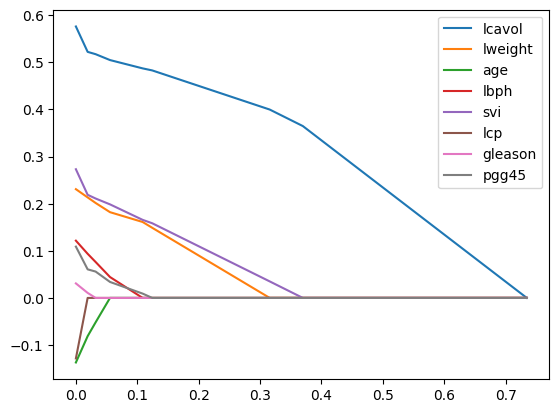

In [8]:
plt.plot(mod_lars.alphas_, mod_lars.coef_path_.T)
plt.legend(df.columns[0:8])
plt.show()

Order in which the variables are included in the model:

In [9]:
order = [
    'lcavol',
    'svi',
    'lweight',
    'pgg45',
    'lbph', 
    'age',
    'gleason',
    'lcp'
]

In [10]:
mod_lars.coef_

array([ 0.57621928,  0.23085294, -0.13704517,  0.12155214,  0.2731707 ,
       -0.1284605 ,  0.03079639,  0.10891159])

### b)

In [11]:
mod_lars.alphas_[0]

0.7344603262136732

### b1)

In [12]:
selected_variables = []

In [13]:
# calculate correlation between each feature and the Y
corrs = [np.corrcoef(X[:,i], Y)[0,1] for i in range(X.shape[1])]
corrs

[0.7344603262136737,
 0.43331938249261975,
 0.16959283918685042,
 0.1798094039414574,
 0.5662182224414467,
 0.5488131747249603,
 0.3689868062872309,
 0.42231585787949766]

In [14]:
s1_ind, s1_name = np.argmax(corrs), df.columns[0:8][np.argmax(corrs)]
s1_ind, s1_name

(0, 'lcavol')

In [15]:
selected_variables.append(s1_ind)

### b2)

In [16]:
mod1 = LinearRegression(fit_intercept=False)
mod1.fit(X[:,s1_ind, np.newaxis], Y)

LinearRegression(fit_intercept=False)

In [17]:
mod1.coef_[0]

0.7344603262136729

### b3)

In [18]:
# code
alpha_values = np.linspace(0, 1, 100)
y_hat = mod1.predict(X[:,s1_ind, np.newaxis])
res_df = pd.DataFrame()
for i, alpha in enumerate(alpha_values):
    residuals = Y - alpha * y_hat
    for j in range(X.shape[1]):
        cor = np.corrcoef(X[:,j], residuals)[0,1]
        res_df = pd.concat(
            [
                res_df,
                pd.DataFrame({"variable": df.columns[j], "correlation": cor, "alpha": alpha},
                                index=[i])
            ])

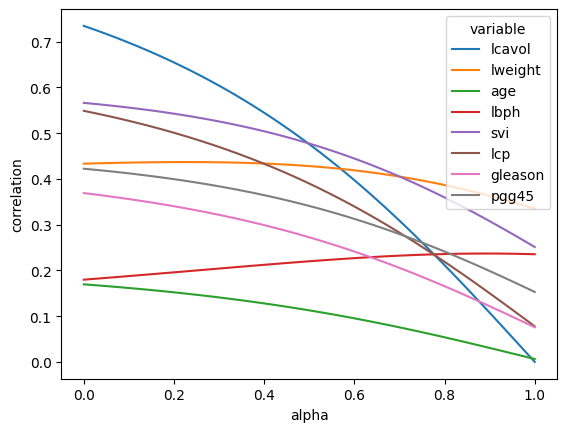

In [19]:
sns.lineplot(data=res_df, x="alpha", y="correlation", hue="variable")
plt.show()

It is the blue line that visualizes the theorem from lecture.  

### b4)

The next variable to be chosen is the one corresponding to purple line, i.e, 'svi', the fifth one (index 4).

In [20]:
residuals = Y - 0.495 * y_hat # 0.495 is the approximated value of alpha
corrs = [np.corrcoef(X[:,i], residuals)[0,1] for i in range(X.shape[1])]
corrs

[0.47957828019458537,
 0.4284156275639239,
 0.11351585681844396,
 0.21963764025459576,
 0.47882112436543606,
 0.3921664092633978,
 0.27382999030472543,
 0.34220401264679773]

In [21]:
np.abs(corrs[0] - corrs[4])

0.0007571558291493141

Yes, $Cor(r_{1, \tilde{\alpha_2}}, X_{S_1}) \approx Cor(r_{1, \tilde{\alpha_2}}, X_{S_2})$.

In [22]:
s2_ind = 4

### b5)

$$ \textrm{Cor}(Y - \tilde\alpha\hat Y, X_i) = ... \cdot\textrm{Cor}(Y, X_i) - ... \cdot \tilde\alpha \cdot \textrm{Cor}(\tilde\alpha\hat Y, X_i) $$

In our case, $i=0$, $j=4$:
$$ |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_i)| = |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_j)|$$

In [23]:
# code
var_Y = 1 
var_Y_hat = np.var(y_hat)
corr_Y_X_prev = np.corrcoef(Y, X[:,s1_ind])[0,1]
corr_Y_X_new = np.corrcoef(Y, X[:,s2_ind])[0,1]
corr_Yhat_X_prev = np.corrcoef(y_hat, X[:,s1_ind])[0,1]
corr_Yhat_X_new = np.corrcoef(y_hat, X[:,s2_ind])[0,1]
alpha_2_tilde = (np.sqrt(var_Y) * corr_Y_X_prev - np.sqrt(var_Y) * corr_Y_X_new) /  \
         (np.sqrt(var_Y_hat) * corr_Yhat_X_prev - np.sqrt(var_Y_hat) * corr_Yhat_X_new)

In [24]:
alpha_2_tilde

0.4967289013871954

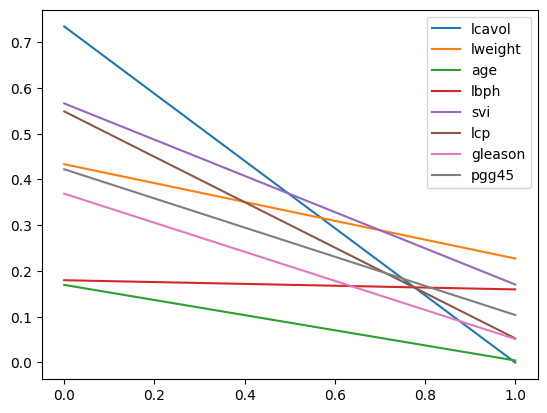

In [25]:
# plot

for i, colname in enumerate(df.columns[0:8]):
    corr_with_Y = np.corrcoef(X[:,i], Y)[0,1]
    corr_with_Yhat = np.corrcoef(X[:,i], y_hat)[0,1]
    plt.plot(alpha_values, np.sqrt(var_Y) * corr_with_Y - alpha_values * np.sqrt(var_Y_hat) * corr_with_Yhat, label=colname)
plt.legend()
plt.show()

### b6)

In [26]:
mod_lars.alphas_

array([0.73446033, 0.36963266, 0.3157    , 0.12438766, 0.10869606,
       0.05558212, 0.03210302, 0.01913394, 0.        ])

In [27]:
alpha_2 = (np.sqrt(var_Y) * np.corrcoef(Y, X[:, s2_ind]) - alpha_2_tilde * np.sqrt(var_Y_hat) * np.corrcoef(y_hat, X[:, s2_ind]))[0, 1]

In [28]:
alpha_2  # equal to value at 2nd position

0.36963265526107475

In [29]:
r1_alpha2 = Y - alpha_2_tilde * y_hat

In [30]:
selected_variables.append(s2_ind)
selected_variables

[0, 4]

### b7)

In [31]:
mod2 = LinearRegression(fit_intercept=False)
mod2.fit(X[:, [s1_ind, s2_ind]], r1_alpha2)
mod2.coef_

array([0.24020136, 0.24020136])

### b8)

In [32]:
# code
alpha_values = np.linspace(0, 1, 100)
y_hat2 = mod2.predict(X[:, [s1_ind, s2_ind]])
res_df = pd.DataFrame()
for i, alpha in enumerate(alpha_values):
    residuals = r1_alpha2 - alpha * y_hat2
    for j in range(X.shape[1]):
        cor = np.corrcoef(X[:, j], residuals)[0, 1]
        res_df = pd.concat(
            [res_df, pd.DataFrame({"variable": df.columns[j], "correlation": cor, "alpha": alpha}, index=[i])]
        )

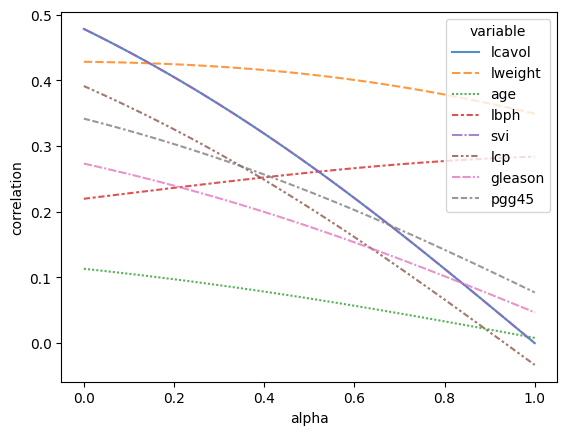

In [33]:
sns.lineplot(data=res_df, x="alpha", y="correlation", hue="variable", style = "variable", alpha=0.8)
plt.show()

Blue and purple lines visualize the theorem from lecture. They correspond to the already selected variables.

### b9)

The next variable to be chosen is the one corresponding to orange line, i.e, 'lweight', the second one (index 1).

In [34]:
residuals = r1_alpha2 - 0.145 * y_hat2 # 0.145 is the approximated value of alpha_tilde_3
corrs = [np.corrcoef(X[:,i], residuals)[0,1] for i in range(X.shape[1])]
corrs

[0.42636228105572915,
 0.4260374662554156,
 0.10195397210942701,
 0.23186717424623474,
 0.4263622810557296,
 0.3446622863014432,
 0.24959414194646143,
 0.3144256807951182]

In [35]:
np.abs(corrs[0] - corrs[1])

0.00032481480031354426

In [36]:
s3_ind = 1

### b10)

In [37]:
# code
var_Y = np.var(r1_alpha2)
var_Y_hat = np.var(y_hat2)
corr_Y_X_prev = np.corrcoef(r1_alpha2, X[:, s2_ind])[0, 1]
corr_Y_X_new = np.corrcoef(r1_alpha2, X[:, s3_ind])[0, 1]
corr_Yhat_X_prev = np.corrcoef(y_hat2, X[:, s2_ind])[0, 1]
corr_Yhat_X_new = np.corrcoef(y_hat2, X[:, s3_ind])[0, 1]
alpha_3_tilde = (np.sqrt(var_Y) * corr_Y_X_prev - np.sqrt(var_Y) * corr_Y_X_new) / (
    np.sqrt(var_Y_hat) * corr_Yhat_X_prev - np.sqrt(var_Y_hat) * corr_Yhat_X_new
)
alpha_3_tilde

0.14590879649354802

### b11)

In [38]:
alpha_3 = (
    np.sqrt(var_Y) * np.corrcoef(r1_alpha2, X[:, s3_ind])
    - alpha_3_tilde * np.sqrt(var_Y_hat) * np.corrcoef(y_hat2, X[:, s3_ind])
)[0, 1]

In [39]:
alpha_3

0.31569999938721677

In [40]:
mod_lars.alphas_ # equal to value at 3rd position

array([0.73446033, 0.36963266, 0.3157    , 0.12438766, 0.10869606,
       0.05558212, 0.03210302, 0.01913394, 0.        ])

In [41]:
r1_alpha3 = r1_alpha2 - alpha_3_tilde * y_hat2

In [42]:
r1_alpha3

array([-1.85675577, -1.48181383, -1.64667929, -1.41029177, -1.61206662,
       -0.65476766, -1.26419267, -1.17172549, -0.50253301, -0.84345637,
       -0.66294497, -0.11670364, -1.12633927, -1.00918404, -0.87263612,
       -0.94497248, -0.25742567, -1.15979322, -0.13082512, -0.34879087,
       -0.64342555, -0.93764697, -0.01704597, -0.79460917, -0.30282135,
       -0.63459153, -0.28675874,  0.03898481, -0.42449487, -0.85129907,
       -0.10097837,  0.00721696, -0.36554846,  0.07761256,  0.10720084,
       -0.30934154, -0.28588433,  0.07313701, -0.74419681,  0.03170987,
        0.10973139, -0.1617637 ,  0.14868113, -0.21545119,  0.00973302,
       -0.02336076, -0.45784475,  0.16087016, -0.01801296,  0.16099146,
        0.26176486,  0.0861285 ,  0.483365  , -0.06121571, -0.39957707,
        0.25540662,  0.41615795,  0.5957098 ,  0.57949517,  0.40776689,
        0.63946004,  0.03926819, -0.14105981,  0.05129211,  0.12327037,
        0.33772067,  0.17392131,  0.15084959,  1.05275857,  0.50

### c) Not yet :)

## Task 2

In [ ]:
X = pd.read_table("data/SRBCT_X.txt", sep=" ")
Y = pd.read_table("data/SRBCT_Y.txt", sep=" ")

X = np.array(X)
Y = np.array(Y)[:,0]

In [ ]:
X = scale(X)
Y = Y - np.mean(Y)

### a)

In [ ]:
mod_lars = Lars(n_nonzero_coefs=80)
# fit

In [ ]:
# plot

In [ ]:
# the order

### b)

In [ ]:
mod_lassolars = LassoLars(alpha=0.15)
# fit

In [ ]:
# order

In [ ]:
# plot

### c)

In [ ]:
lasso_coef = np.zeros((X.shape[1], mod_lassolars.alphas_.shape[0]))

In [ ]:
for i in range(mod_lassolars.alphas_.shape[0]):
    mod_lasso = Lasso(alpha=mod_lassolars.alphas_[i])
    mod_lasso.fit(X, Y)

    lasso_coef[:,i] = mod_lasso.coef_

In [ ]:
# plot